# Import libraries

In [274]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import datetime
import numpy as np
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.ensemble import RandomForestClassifier

In [275]:
warnings.filterwarnings("ignore")

# Data Import

In [276]:
df = pd.read_csv("clean_data.csv")

In [277]:
pd.set_option('display.max_columns', None)

In [278]:
new_column_names = {'Dates Review': 'date_review',
                    'Day Review': 'day_review',
                    'Month Review': 'month_review',
                   'Month Review Number': 'month_review_num',
                   'Year Review': 'year_review',
                   'Verified': 'verified',
                   'Customer Name':'name',
                   'Month Flown': 'month_fly',
                   'Month Flown Number': 'month_fly_num',
                    'Year Flown':'year_fly',
                   'Month Year Flown': 'month_year_fly',
                   'Country': 'country',
                   'Aircraft': 'aircraft',
                   'Type Of Traveller': 'type',
                   'Seat Type': 'seat_type',
                   'Route': 'route',
                   'Seat Comfort': 'seat_comfort',
                   'Cabin Staff Service': 'cabit_serv',
                   'Food & Beverages': 'food',
                   'Ground Service': 'ground_service',
                   'Wifi & Connectivity': 'wifi',
                   'Value For Money': 'money_value',
                   'Recommended': 'recommended',
                   'Review': 'review'}

df.rename(columns=new_column_names, inplace=True)

In [279]:
df = df.drop(columns=['month_fly', 'month_fly_num','year_fly', 'day_review', 'month_review', 'month_review_num', 'year_review'])

In [280]:
df.dtypes

ID                  int64
date_review        object
verified             bool
name               object
month_year_fly     object
country            object
aircraft           object
type               object
seat_type          object
route              object
seat_comfort      float64
cabit_serv        float64
food              float64
ground_service    float64
wifi              float64
money_value         int64
recommended        object
review             object
dtype: object

In [281]:
df['recommended'] = df['recommended'].replace({'yes': 1, 'no': 0})
df['verified'] = df['verified'].astype('str')
df['verified'] = df['verified'].replace({'True': 1, 'False': 0})

In [282]:
df['aircraft'].fillna(0, inplace=True)
df['wifi'].fillna(0, inplace=True)
df['aircraft'] = df['aircraft'].apply(lambda x: 1 if x != 0 else 0)
df['wifi'] = df['wifi'].apply(lambda x: 1 if x != 0 else 0)

In [283]:
df['date_review'] = df['date_review'].astype('datetime64[ns]')
df['month_year_fly'] = df['month_year_fly'].astype('datetime64[ns]')
df['seat_comfort'] = pd.to_numeric(df['seat_comfort'], errors='coerce').astype('Int64')
df['cabit_serv'] = pd.to_numeric(df['cabit_serv'], errors='coerce').astype('Int64')
df['food'] = pd.to_numeric(df['food'], errors='coerce').astype('Int64')
df['ground_service'] = pd.to_numeric(df['ground_service'], errors='coerce').astype('Int64')

In [284]:
df.dtypes

ID                         int64
date_review       datetime64[ns]
verified                   int64
name                      object
month_year_fly    datetime64[ns]
country                   object
aircraft                   int64
type                      object
seat_type                 object
route                     object
seat_comfort               Int64
cabit_serv                 Int64
food                       Int64
ground_service             Int64
wifi                       int64
money_value                int64
recommended                int64
review                    object
dtype: object

In [285]:
df.head(3)

,ID,date_review,verified,name,month_year_fly,country,aircraft,type,seat_type,route,seat_comfort,cabit_serv,food,ground_service,wifi,money_value,recommended,review
0,0,2024-02-23,1,Peter Hansell,2023-09-01,United Kingdom,0,Couple Leisure,Economy Class,Pisa to London Heathrow,<NA>,<NA>,<NA>,<NA>,0,1,0,That was supposed to be my flight but it was c...
1,1,2024-02-21,1,Caleb Lowe,2024-02-01,United Kingdom,1,Couple Leisure,Business Class,Malaga to London Heathrow,5,5,5,4,0,4,1,Have no fear when your BA flight is operated b...
2,2,2024-02-17,0,Kevin Statham,2024-02-01,United States,1,Couple Leisure,Economy Class,Phoenix to Lisbon via London,1,5,3,1,1,1,0,We have flown BA five times from western USA t...


# Null Handling

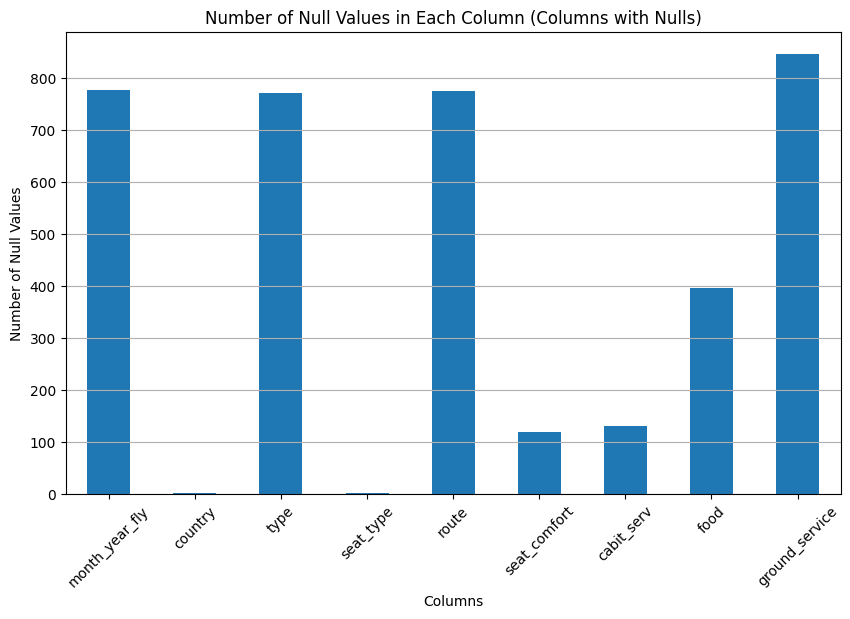

In [286]:
null_counts = df.isnull().sum()

null_counts_filtered = null_counts[null_counts > 0]

null_counts_filtered.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Null Values in Each Column (Columns with Nulls)')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45)  
plt.grid(axis='y')  
plt.show()

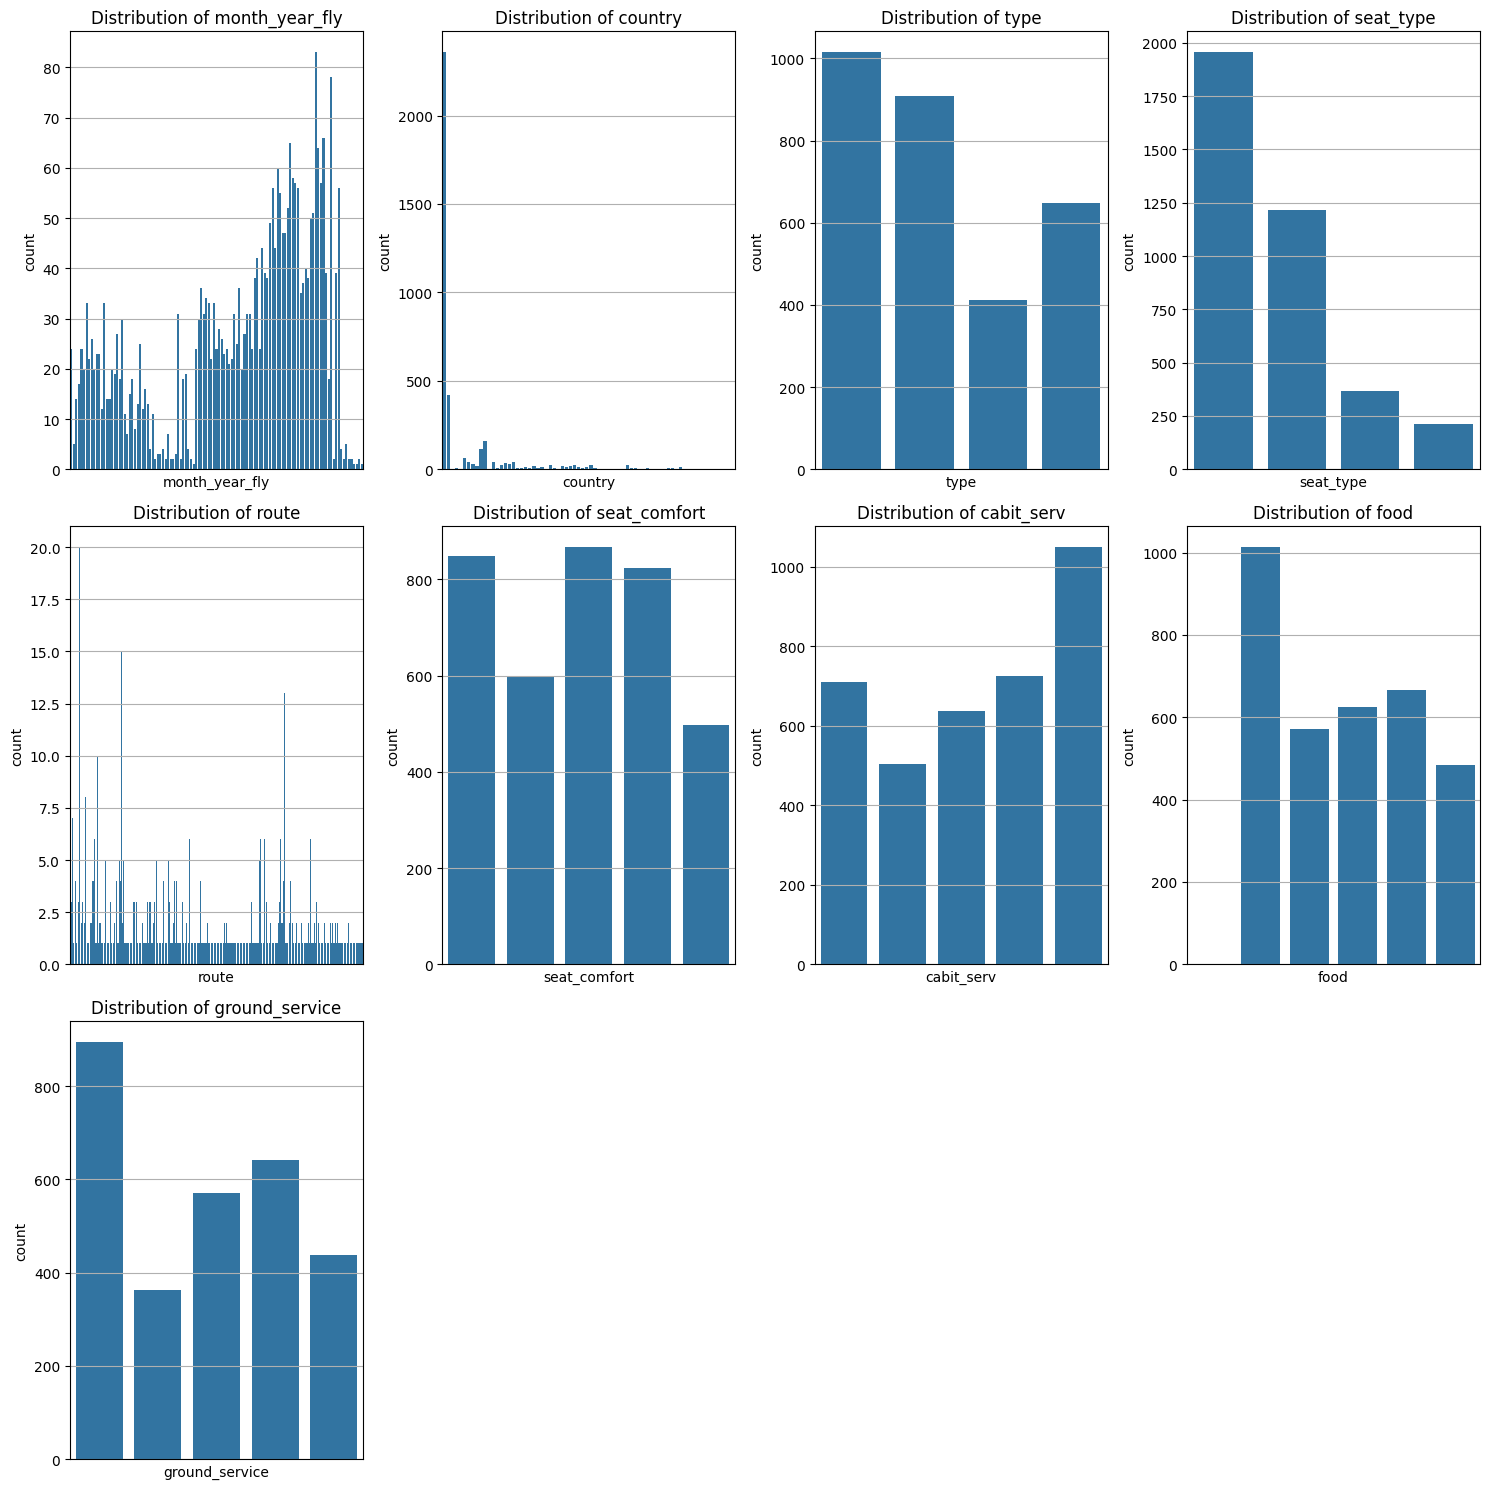

In [287]:
categorical_columns = ['month_year_fly','country', 'type', 'seat_type', 'route', 
                       'seat_comfort', 'cabit_serv', 'food', 'ground_service']

num_columns = 4
num_rows = (len(categorical_columns) - 1) // num_columns + 1

plt.figure(figsize=(15, num_rows*5))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.countplot(data=df, x=column)
    plt.title(f'Distribution of {column}')
    plt.grid(axis='y')
    plt.xticks([])
plt.tight_layout()
plt.show()

In [288]:
# Handling month/year/date NAs
df_sorted = df.sort_values(by='month_year_fly')
df['month_year_fly'] = df_sorted['month_year_fly'].fillna(method='ffill')

In [289]:
# Handling 'seat_comfort', 'cabit_serv', 'food', 'ground_service'
columns_with_missing = ['seat_comfort', 'cabit_serv', 'food', 'ground_service']
imputer = KNNImputer(n_neighbors=5)
df[columns_with_missing] = imputer.fit_transform(df[columns_with_missing])

In [290]:
review_columns = ['seat_comfort', 'cabit_serv', 'food', 'ground_service', 'wifi']
df[review_columns] = df[review_columns].round()

In [291]:
# Handling 'country' and 'seat_type' NAs
df['country'].fillna(df['country'].mode()[0], inplace = True)
df['seat_type'].fillna(df['seat_type'].mode()[0], inplace = True)

In [292]:
# Handling 'type' NAs
df_with_type = df[df['type'].notna()]
df = df[df['type'].isna()]